# Dynamic Pricing Evolution: Random vs Heuristic Strategy

Simple visualization showing how pricing strategy evolves from random to heuristic.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util

# Import the environment
spec = importlib.util.spec_from_file_location("pricing_env", "02_dynamic_pricing_env.py")
pricing_env = importlib.util.module_from_spec(spec)
spec.loader.exec_module(pricing_env)
DynamicPricingEnv = pricing_env.DynamicPricingEnv

# USER CONTROLS
TOTAL_PERIODS = 8           # Selling periods
INITIAL_INVENTORY = 40      # Starting stock
PRICE_LEVELS = [6, 10, 14, 18]  # Available price points


In [7]:
class RandomAgent:
    """Completely random pricing agent"""
    def choose_action(self, state, price_levels):
        return np.random.randint(0, len(price_levels))

class HeuristicAgent:
    """Simple heuristic pricing agent"""
    def choose_action(self, state, price_levels):
        time_left = state['time_periods_left']
        
        # Simple rule: start expensive, get cheaper as time runs out
        # price_levels = [6, 10, 14, 18] -> indices [3, 2, 1, 0]
        
        if time_left >= 7:     # Early: highest price
            return 0           # $18
        elif time_left >= 5:   # Mid-early: second highest
            return 1           # $14  
        elif time_left >= 3:   # Mid-late: second lowest
            return 2           # $10
        else:                  # Late: lowest price
            return 3           # $6


In [8]:
def run_agent_episode(agent, agent_name, env):
    """Run agent through an episode and return results"""
    state = env.reset()
    total_revenue = 0
    price_decisions = []
    
    while state['time_periods_left'] > 0:
        action = agent.choose_action(state, env.price_levels)
        state, reward, done, info = env.step(action)
        
        total_revenue += info['revenue_this_period']
        price_decisions.append(info['price_chosen'])
        
        if done:
            break
    
    final_inventory = state['current_inventory']
    
    return {
        'total_revenue': total_revenue,
        'final_inventory': final_inventory,
        'price_decisions': price_decisions,
        'items_sold': INITIAL_INVENTORY - final_inventory
    }


Dynamic Pricing Environment:
  Periods: 8
  Initial Inventory: 40
  Price Options: [6, 10, 14, 18]
\n🎯 Running single episode comparison...
\n📊 SINGLE EPISODE RESULTS:
Random Agent:    $120 revenue, 20 sold, 20 unsold
Heuristic Agent: $60 revenue, 10 sold, 30 unsold


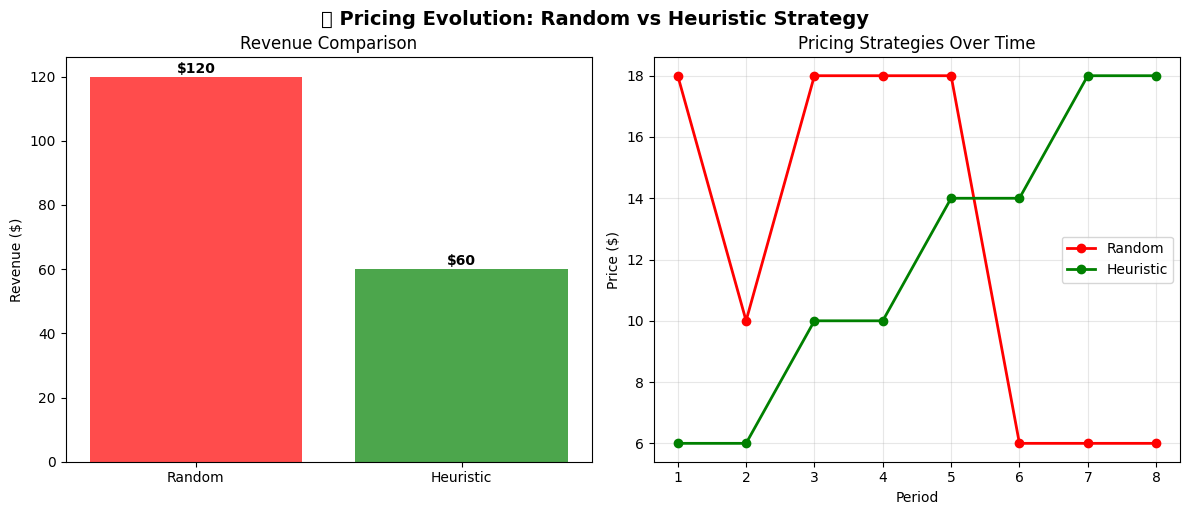

In [9]:
# 🏪 Create Environment
env = DynamicPricingEnv(
    total_time_periods=TOTAL_PERIODS,
    initial_inventory=INITIAL_INVENTORY,
    price_levels=PRICE_LEVELS,
    base_demand_per_period=12,
    price_sensitivity=1.2,
    unsold_penalty_per_item=1.0
)

print(f"Dynamic Pricing Environment:")
print(f"  Periods: {TOTAL_PERIODS}")
print(f"  Initial Inventory: {INITIAL_INVENTORY}")
print(f"  Price Options: {PRICE_LEVELS}")

# 💰 Create Agents
random_agent = RandomAgent()
heuristic_agent = HeuristicAgent()

print("\\n🎯 Running single episode comparison...")

# Test both agents
random_result = run_agent_episode(random_agent, "Random", env)
heuristic_result = run_agent_episode(heuristic_agent, "Heuristic", env)

# Show results
print(f"\\n📊 SINGLE EPISODE RESULTS:")
print(f"Random Agent:    ${random_result['total_revenue']:.0f} revenue, {random_result['items_sold']} sold, {random_result['final_inventory']} unsold")
print(f"Heuristic Agent: ${heuristic_result['total_revenue']:.0f} revenue, {heuristic_result['items_sold']} sold, {heuristic_result['final_inventory']} unsold")

# Simple comparison chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Revenue comparison
agents = ['Random', 'Heuristic']
revenues = [random_result['total_revenue'], heuristic_result['total_revenue']]
colors = ['red', 'green']

bars1 = ax1.bar(agents, revenues, color=colors, alpha=0.7)
ax1.set_ylabel('Revenue ($)')
ax1.set_title('Revenue Comparison')
for bar, rev in zip(bars1, revenues):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(revenues)*0.01, 
             f'${rev:.0f}', ha='center', fontweight='bold')

# Price strategies
ax2.plot(range(1, len(random_result['price_decisions']) + 1), random_result['price_decisions'], 
         'ro-', label='Random', linewidth=2)
ax2.plot(range(1, len(heuristic_result['price_decisions']) + 1), heuristic_result['price_decisions'], 
         'go-', label='Heuristic', linewidth=2)
ax2.set_xlabel('Period')
ax2.set_ylabel('Price ($)')
ax2.set_title('Pricing Strategies Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('💰 Pricing Evolution: Random vs Heuristic Strategy', fontsize=14, fontweight='bold', y=1.02)
plt.show()


\n🔄 Running multiple episodes to show consistency...
\n📊 EVOLUTION SUMMARY (10 runs):
Random Agent:    $48 avg revenue, 8.0 avg sold
Heuristic Agent: $59 avg revenue, 9.9 avg sold
\n🚀 Improvement: 24% better revenue, 24% more items sold!


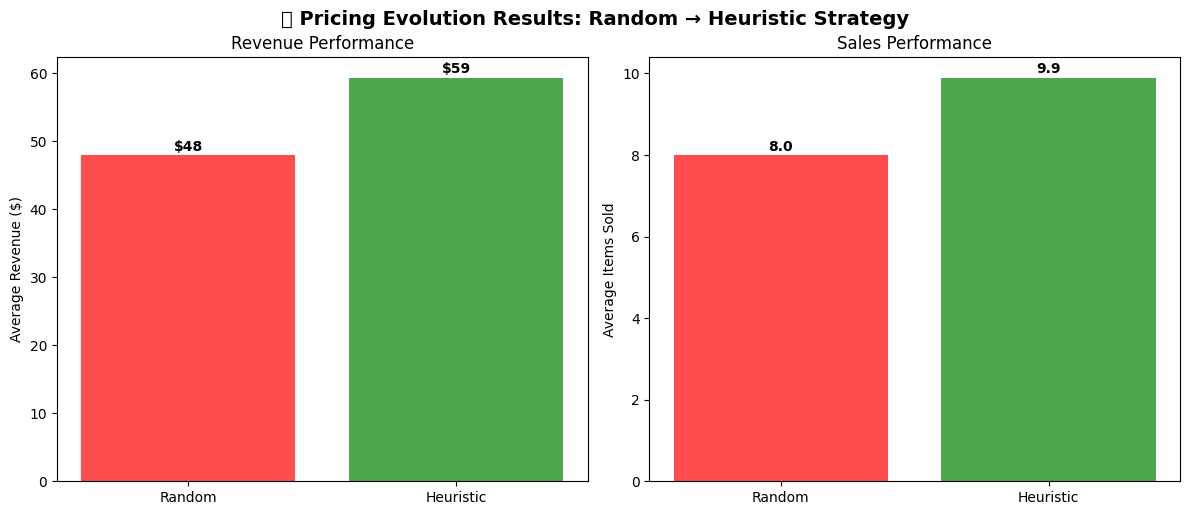

In [10]:
# 📈 Multiple Runs Analysis
print("\\n🔄 Running multiple episodes to show consistency...")

random_revenues = []
heuristic_revenues = []
random_sold = []
heuristic_sold = []

NUM_RUNS = 10

for run in range(NUM_RUNS):
    # Random agent
    random_result = run_agent_episode(random_agent, "Random", env)
    random_revenues.append(random_result['total_revenue'])
    random_sold.append(random_result['items_sold'])
    
    # Heuristic agent
    heuristic_result = run_agent_episode(heuristic_agent, "Heuristic", env)
    heuristic_revenues.append(heuristic_result['total_revenue'])
    heuristic_sold.append(heuristic_result['items_sold'])

print(f"\\n📊 EVOLUTION SUMMARY ({NUM_RUNS} runs):")
print(f"Random Agent:    ${np.mean(random_revenues):.0f} avg revenue, {np.mean(random_sold):.1f} avg sold")
print(f"Heuristic Agent: ${np.mean(heuristic_revenues):.0f} avg revenue, {np.mean(heuristic_sold):.1f} avg sold")

if np.mean(random_revenues) > 0:
    improvement_revenue = ((np.mean(heuristic_revenues) - np.mean(random_revenues)) / np.mean(random_revenues)) * 100
    improvement_sales = ((np.mean(heuristic_sold) - np.mean(random_sold)) / np.mean(random_sold)) * 100
    print(f"\\n🚀 Improvement: {improvement_revenue:.0f}% better revenue, {improvement_sales:.0f}% more items sold!")

# Final visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Revenue comparison
agents = ['Random', 'Heuristic']
avg_revenues = [np.mean(random_revenues), np.mean(heuristic_revenues)]
colors = ['red', 'green']

bars1 = ax1.bar(agents, avg_revenues, color=colors, alpha=0.7)
ax1.set_ylabel('Average Revenue ($)')
ax1.set_title('Revenue Performance')
for bar, rev in zip(bars1, avg_revenues):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(avg_revenues)*0.01, 
             f'${rev:.0f}', ha='center', fontweight='bold')

# Sales comparison  
avg_sold = [np.mean(random_sold), np.mean(heuristic_sold)]
bars2 = ax2.bar(agents, avg_sold, color=colors, alpha=0.7)
ax2.set_ylabel('Average Items Sold')
ax2.set_title('Sales Performance')
for bar, sold in zip(bars2, avg_sold):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(avg_sold)*0.01, 
             f'{sold:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.suptitle('💰 Pricing Evolution Results: Random → Heuristic Strategy', fontsize=14, fontweight='bold', y=1.02)
plt.show()
